In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from Utils.build_dataset import paths_dataset_shrimp
from torchvision import transforms
from Models.linknet_model import linkNet
from Utils.FishDataset import FishDataset
from Utils.training import training_loop, predict, iou_np
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import cv2
import os

In [2]:
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda:0


In [3]:
label_dict = {0 : "Black Sea Sprat", 1 : "Sea Bass", 2 : "Red Mullet", 3 : "Trout", 4 : "Striped Red Mullet", 
              5 : "Shrimp", 6 : "Red Sea Bream", 7 : "Hourse Mackerel", 8 : "Gilt-Head Bream"}

## Carregando as Imagens

In [4]:
path = 'Dataset/Fish_Dataset/Fish_Dataset/Shrimp/'
df_train_pd, df_valid_pd, df_test_pd = paths_dataset_shrimp(path)

In [5]:
img_size = 256
threshold = 0.5
transforms = transforms.Compose([transforms.ToPILImage(), transforms.Resize((img_size, img_size)), transforms.ToTensor()])

In [6]:
df_train = FishDataset(df_train_pd, transforms, transforms)

In [7]:
df_valid = FishDataset(df_valid_pd, transforms, transforms)

In [8]:
df_test = FishDataset(df_test_pd, transforms, transforms)

In [9]:
df_train[0][1].shape

torch.Size([1, 256, 256])

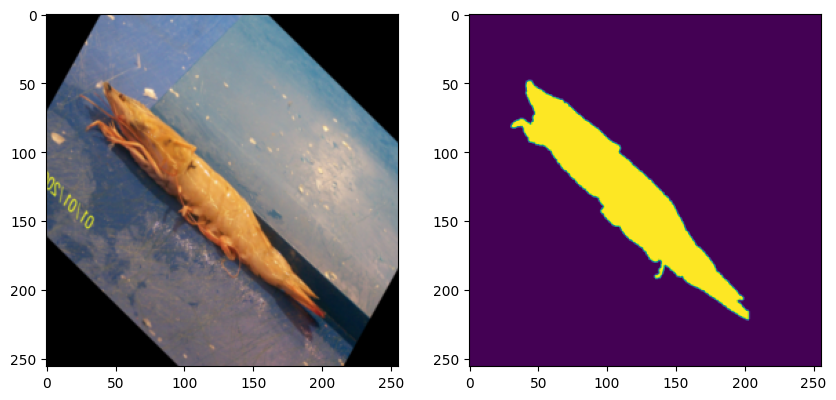

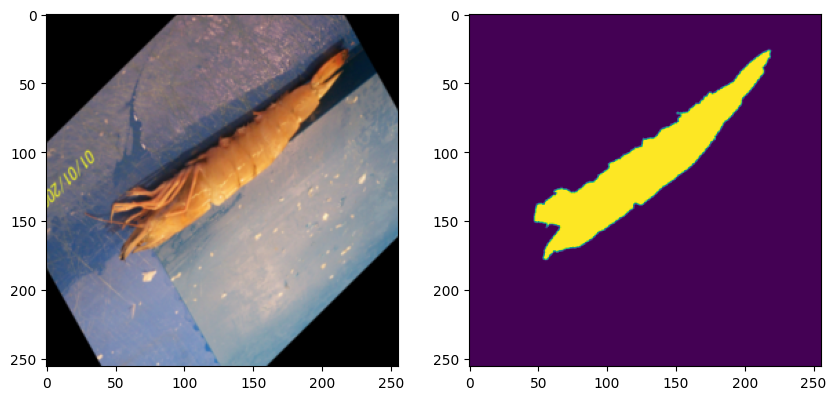

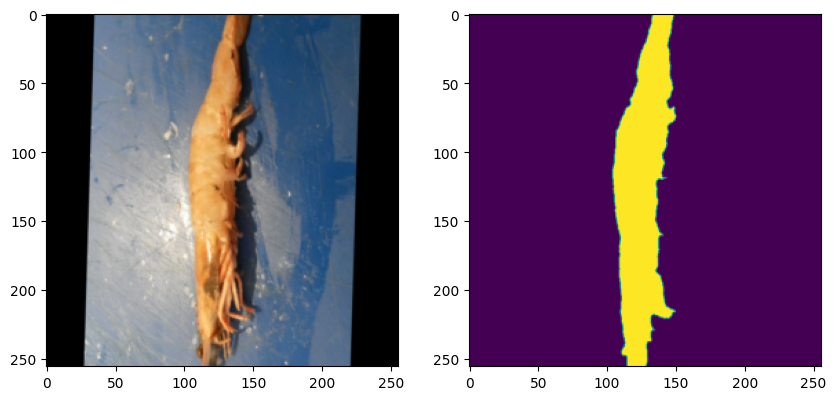

In [10]:
for i in range(3):
    n = random.randint(0, (len(df_train)))
    fig = plt.figure(figsize=(10, 100))
    
    fig.add_subplot(15, 2, 1)
    #plt.title(label_dict[df_train[n][2]])
    plt.imshow(df_train[n][0].permute(1, 2, 0))
    
    fig.add_subplot(15, 2, 2)
    #plt.title(label_dict[df_train[n][2]])
    plt.imshow(df_train[n][1].permute(1, 2, 0))

## Construindo o Modelo

In [11]:
model = linkNet()
model.to(device, dtype=dtype)

linkNet(
  (_mconv_1): conv_block(
    (_mconv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block_relu): ReLU(inplace=True)
    )
  )
  (_mmax_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (_mencoder_1): encoder(
    (_mres_1): res_block(
      (_mconv_2): conv_block(
        (_mconv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (_mconv_1): conv_block(
        (_mconv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_block_relu): ReLU(inplace=True)
        )
      )
      (_mdownsample

In [12]:
epochs = 30
batch_size = 32
lr = 1e-3
train_loader = DataLoader(df_train, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(df_valid, batch_size=batch_size, shuffle=False, num_workers=4)
criterion = torch.nn.BCEWithLogitsLoss()
sigmoid = torch.nn.Sigmoid()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [13]:
len(train_loader.dataset)

600

In [14]:
model, optimizer, train_losses, valid_losses, train_iou_list, valid_iou_list = training_loop(epochs, model, train_loader, valid_loader, criterion, optimizer, device, dtype)

Epoch 1 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:17<00:00,  1.07it/s]


Train loss: 0.3676	Valid loss: 0.4677	Train IoU: 65.80	Valid IoU: 0.10
Epoch 2 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.43it/s]


Train loss: 0.2117	Valid loss: 0.2260	Train IoU: 80.48	Valid IoU: 67.75
Epoch 3 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.45it/s]


Train loss: 0.1672	Valid loss: 0.1885	Train IoU: 81.19	Valid IoU: 49.91
Epoch 4 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.40it/s]


Train loss: 0.1360	Valid loss: 0.1195	Train IoU: 82.69	Valid IoU: 79.69
Epoch 5 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.36it/s]


Train loss: 0.1130	Valid loss: 0.1024	Train IoU: 83.02	Valid IoU: 80.15
Epoch 6 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.43it/s]


Train loss: 0.0965	Valid loss: 0.0904	Train IoU: 83.24	Valid IoU: 84.01
Epoch 7 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.39it/s]


Train loss: 0.0829	Valid loss: 0.0751	Train IoU: 83.37	Valid IoU: 81.82
Epoch 8 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.43it/s]


Train loss: 0.0732	Valid loss: 0.0737	Train IoU: 83.64	Valid IoU: 81.35
Epoch 9 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.40it/s]


Train loss: 0.0658	Valid loss: 0.0655	Train IoU: 83.90	Valid IoU: 84.35
Epoch 10 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.39it/s]


Train loss: 0.0593	Valid loss: 0.0554	Train IoU: 83.90	Valid IoU: 83.02
Epoch 11 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.43it/s]


Train loss: 0.0537	Valid loss: 0.0546	Train IoU: 84.46	Valid IoU: 80.79
Epoch 12 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.39it/s]


Train loss: 0.0493	Valid loss: 0.0494	Train IoU: 84.53	Valid IoU: 82.97
Epoch 13 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.37it/s]


Train loss: 0.0461	Valid loss: 0.0466	Train IoU: 84.54	Valid IoU: 83.62
Epoch 14 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.43it/s]


Train loss: 0.0425	Valid loss: 0.0435	Train IoU: 84.67	Valid IoU: 85.43
Epoch 15 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.39it/s]


Train loss: 0.0402	Valid loss: 0.0447	Train IoU: 84.94	Valid IoU: 85.17
Epoch 16 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.45it/s]


Train loss: 0.0379	Valid loss: 0.0415	Train IoU: 85.10	Valid IoU: 84.15
Epoch 17 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.44it/s]


Train loss: 0.0362	Valid loss: 0.0429	Train IoU: 85.15	Valid IoU: 80.91
Epoch 18 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.39it/s]


Train loss: 0.0341	Valid loss: 0.0398	Train IoU: 85.52	Valid IoU: 84.15
Epoch 19 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.46it/s]


Train loss: 0.0324	Valid loss: 0.0368	Train IoU: 85.67	Valid IoU: 84.62
Epoch 20 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.40it/s]


Train loss: 0.0307	Valid loss: 0.0359	Train IoU: 85.99	Valid IoU: 83.26
Epoch 21 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.42it/s]


Train loss: 0.0303	Valid loss: 0.0392	Train IoU: 86.16	Valid IoU: 86.15
Epoch 22 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.45it/s]


Train loss: 0.0329	Valid loss: 0.0408	Train IoU: 84.85	Valid IoU: 83.61
Epoch 23 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.39it/s]


Train loss: 0.0317	Valid loss: 0.0380	Train IoU: 85.16	Valid IoU: 85.41
Epoch 24 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.33it/s]


Train loss: 0.0290	Valid loss: 0.0390	Train IoU: 86.32	Valid IoU: 82.30
Epoch 25 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.45it/s]


Train loss: 0.0282	Valid loss: 0.0389	Train IoU: 86.31	Valid IoU: 79.10
Epoch 26 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.40it/s]


Train loss: 0.0274	Valid loss: 0.0380	Train IoU: 86.25	Valid IoU: 84.59
Epoch 27 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.45it/s]


Train loss: 0.0252	Valid loss: 0.0352	Train IoU: 87.13	Valid IoU: 86.11
Epoch 28 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.43it/s]


Train loss: 0.0236	Valid loss: 0.0336	Train IoU: 87.80	Valid IoU: 83.25
Epoch 29 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.39it/s]


Train loss: 0.0225	Valid loss: 0.0319	Train IoU: 87.70	Valid IoU: 83.38
Epoch 30 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.45it/s]


Train loss: 0.0218	Valid loss: 0.0359	Train IoU: 87.91	Valid IoU: 87.14


In [15]:
torch.save(model.state_dict(), "Saved Models/linknet_shrimp.pkl")

### Carregando Modelo

In [12]:
model.load_state_dict(torch.load("Saved Models/linknet_shrimp.pkl"))

<All keys matched successfully>

## Avaliando o Modelo

In [16]:
test_loader = DataLoader(df_test, batch_size=batch_size, shuffle=False, num_workers=4)

In [17]:
model.eval()
model.to(device)

linkNet(
  (_mconv_1): conv_block(
    (_mconv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block_relu): ReLU(inplace=True)
    )
  )
  (_mmax_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (_mencoder_1): encoder(
    (_mres_1): res_block(
      (_mconv_2): conv_block(
        (_mconv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (_mconv_1): conv_block(
        (_mconv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_block_relu): ReLU(inplace=True)
        )
      )
      (_mdownsample

In [18]:
img_list_test = list(df_test_pd['image'])
mask_list_test = list(df_test_pd['mask'])

In [19]:
running_iou = 0

for i in range(len(img_list_test)):
    image = cv2.imread(img_list_test[i])
    image = cv2.resize(image, (img_size, img_size))
    mask = cv2.imread(mask_list_test[i])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (img_size, img_size))
    pred = predict(model, image, img_size, threshold, device)
    iou_pred = iou_np(mask, pred)
    running_iou += iou_pred

iou_test = (running_iou / len(img_list_test)) * 100
print(f'IoU: {iou_test:.1f}')

IoU: 90.8


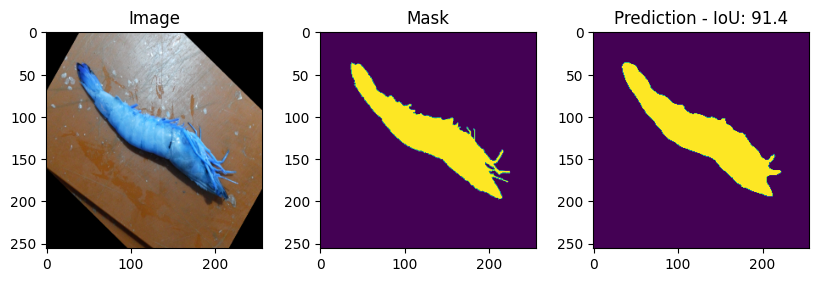

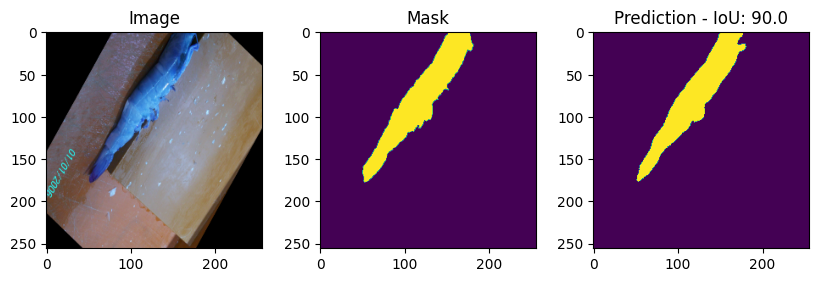

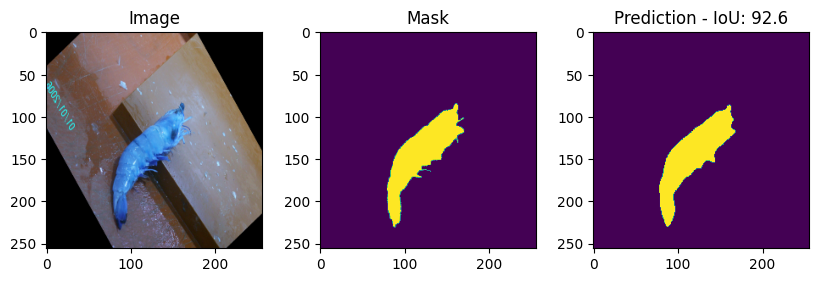

In [20]:
for i in range(3):
    n = random.randint(0, (len(img_list_test)))
    fig = plt.figure(figsize=(10, 50))
    
    image = cv2.imread(img_list_test[n])
    image = cv2.resize(image, (img_size, img_size))
    mask = cv2.imread(mask_list_test[n])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (img_size, img_size))
    pred = predict(model, image, img_size, threshold, device)
    iou = iou_np(mask, pred) * 100
    
    
    fig.add_subplot(15, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    
    fig.add_subplot(15, 3, 2)
    plt.title('Mask')
    plt.imshow(mask)
    
    fig.add_subplot(15, 3, 3)
    plt.title(f'Prediction - IoU: {iou:.1f}')
    plt.imshow(pred)